## Solving a large scale constrained non linear program for operations research with gradient descent

- Task surveying
- Problem Formulation
- Introductory example
- Scipy 
- CVXPY
- Solution with gradient descent
- Alternative geometric approach
- Extra comments on deployment:
    - Docker
    - Cloud Services
    - Flask API with GPU support
    - MSSQL Server

### Project surveing

When solving data science tasks for education purposes or in online challenges (ej. Kaggle), the problem objective is given explicitly, and many times even with adequate metrics. In the industry that is not always the case, as it is frequent that clients do not bring forward a directly tractable formulation of the problem or a _Key Performance Indicator_. The optimization objective may not be trivial, so it is on the data scientist to define a formal statement. The task addressed is to distribute the stock for the next period, subject to different sets of constraints and avoiding large variations in a given vendor. Taking this inventory allocation case as an example, we would not expect the user to know that the adequate L-norm for his allocation strategy was L-\\(\infty\\). More even, the hierarchy of groupings given by the user may have been coded as a high dimensional tensor, a tree, hypergraph, or flattened vector. Let alone the strategy for the solution.

A couple of initial meetings were required to design the interface, delimit the convenient functionalities, and planning the deployment infrastructure. As I managed the development completely, I had to take into account aspects like client relationship, cost estimations, validation, and deployment. Coming from a more research-oriented career, there are points to keep an eye on as for example, be very wary about promising dates and aim to overestimate 😅. Along the way, we met for the team of analysts to audit the solution and modify the scope and specs. 

#### Problem statement

In the abstract, optimization in this context is the process of choosing the best possible vector \\(\in R^n\\) from a set. In this way, it encompasses many ways of decision making, and so the reason for its ubiquitous relevance. The general formulation is: 

$$\begin{aligned}
& \underset{x}{\text{minimize}}
& & f(x) \\
& \text{subject to}
& & f_i(x) \leq b_i, \; i = 1, \ldots, m.
\end{aligned}$$

In our case, the problem consists of allocating certain inventory to their possible outlets minimizing the variation with respect to the previous period, and while satisfying arbitrary constraints defined on hierarchical and overlapping categories. A stock of a \\(p \in \mathbb{N^i}\\) products has to be allocated to \\(s \in \mathbb{N^j}\\) outlets. Equality and inequality restrictions intend to modulate sales in different areas, allow compliance to commercial agreements, and respond to diverse business needs. Both \\(p\\) and \\(s\\) are classified in multiple hierarchical levels, e.g. : _channel, area, group, delivery route..._ for \\(s\\); _family, product, flavor..._ for \\(p\\). 
    One possibility for the formulation is to organize this levels into a  but forcing symetry would conveys extra memory consumption assigning redundant space (allocating a quantity of each product for each outlet when not all products are sold at all outlets). Therefore a vector is constructed as \\(\textbf{q} = (s_0p_0, ..., s_ip_j)\\), \\(\textbf{q} \in \mathbb{R}^{i \times j}\\) where \\(p_is_j\\) corresponds to the quantity of product \\(i\\) in outlet \\(j\\), and excluding the elements \\(i,j\\) that are not applicable for the period distribution. Continuous relaxation of the \\(q\\) vector is allowed for faster computation. The optimization problem is formulated as:

If all $f_i(x)$ fulfil linearity conditions, \\(f_i(αx + βy) = αf_i(x) + βf_i(y)\\), then the problem corresponds to a _linear program_. A more general class of problems consist of all that comply \\(f_i(αx + βy) ≤ αf_i(x) + βf_i(y)\\) given \\(α, β \in [0,1], α + β = 1\\), corresponding to the domain of _convex problems_. Finally, with \\(x \in \mathbb{Z}\\), a _Mixed Integer Convex Non-Linear Program_ can be defined.

$$\begin{aligned}
\underset{q}{\text{minimize }}
& 
| ( \mathbf{q} - \mathbf{q_{0}} ) \oslash  \mathbf{q_{0}} |^{\infty}
\\ \text{subject to: } 
& \textbf{R}\textbf{q} = \textbf{b} \\ 
& \textbf{M}\textbf{q} \leq \textbf{d}
\end{aligned}$$

Where each row \\(r\\) in \\(R \in \{0,1\}^{i \times j}\\) represents a restriction and is defined as \\(r_i = 1\\) if the corresponding element in \\(\textbf{q}\\) is in the subset to which the restriction applies. The symbol \\(\oslash\\) corresponds to element-wise (or Hadamard) division.

<!-- TEASER_END -->

The article is not at all finished. Much pruning, writting, and editing to do. Proceed at your own risk!

#### Solution 1

The general idea is to calculate the contribution of each variable $q_{ij}$ to each restriction, and average that quantity over all restrictions to apply a gradient descent $\Delta$ on vector $q$. 

In [1]:
#This solution runs in $\mathcal{O} ...$ time, converging to a value that minimizes a combination of $\ell \text{-} 2$ and $\ell\text{-}\infty$ norms. 

$$\text{Init } \textbf{q*} := q_0 $$
$$\text{Repeat until convergence:}$$

$$\textbf{e} = \textbf{b} \oslash \textbf{R} \cdot \textbf{q*}$$
$$\textbf{R*} = diag( \textbf{e}) \cdot \textbf{R}$$
$$\Delta_{j} = \frac{1}{i}\sum_{\{i: R*_{ij} \neq 0\}} \textbf{R*}_{ij}$$
$$\textbf{q*} = \textbf{q} \odot \Delta$$

#### Solution 2
This second solution consists on using a weighted inner product given by matrix $\textbf{W}$, that makes the norm proportional to the previous vector $\textbf{q}_0$. A first solution to the $\textbf{R}\textbf{q} = \textbf{b}$ system is calculated to proyect the variety of solutions to a subspace. Then the previous vector $q_0$ is proyected to this subspace using as inner product the matrix $\textbf{W}$ the so to find the closest vector than 




$$\textbf{W} = diag(\textbf{q}_0)$$
$$\textbf{s} =  \textit{Least squares}[\textbf{R}\textbf{q} = \textbf{b}]$$
$$\textbf{q*} = \textbf{q}_0 - \textbf{s}$$
$$\textbf{o} = \textit{Orth}[(R \cdot W)^T]$$
$$\textbf{v} = \textbf{W} \cdot o$$
$$\textbf{x} = \textbf{o} - \textbf{v} \cdot (v^T \cdot \textbf{W}^{-2} \cdot \textbf{o})$$
$$\textbf{q} = x + s$$

For least squares, LSQR algorithm is used (c), and the orthogonal basis $o$ is computed using singular value decomposition.

In [1]:
import numpy as np
import re
from scipy import sparse
import scipy.linalg as linalg
from scipy.sparse import csr_matrix, save_npz, load_npz, diags
from scipy.sparse.linalg import lsqr
from scipy.linalg import orth

In [1]:
import pyodbc 
import re
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# Extras para visualizar
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
sns.set()
%matplotlib notebook
CSS = ".output {flex-direction: row;}"
HTML('<style>{}</style>'.format(CSS))
np.set_printoptions(precision=3, suppress=True)

In [2]:
# Warnings que no afectan. Runtime es por fila en A que es = 0
import warnings
warnings.filterwarnings("ignore",category= DeprecationWarning)
warnings.filterwarnings("ignore",category= FutureWarning)
warnings.filterwarnings("ignore",category= RuntimeWarning)

In [3]:
def check_sol(A, q, b, Q, show=True, th1=1, th2=0.3):
    """Muestra un resumen informativo del resultado
    A: Matriz binaria de restricciones
    q: vector a optimizar, en ppio es WarmStart
    b: vector con los objetivos de las restricciones (incluye ineqs)
    th: se enumera n > th1 y n > th2"""
    
    Q['Dif'] = Q['Z'] / Q['WarmStart']
    
    data = (np.linalg.norm(Q['Dif'], ord=2), 
            Q['Dif'].max(), 
            Q['Dif'].min(),
            Q['Dif'].mean(),   
            Q.loc[Q['Dif'].abs() > th1].shape[0],
            Q.loc[Q['Dif'].abs() > th2].shape[0], 
            Q[Q['Z'] < 0].shape[0], 
            np.linalg.norm(A @ q - b))
    
    names = f'Norma, Max, Min, Media, Mayores a {th1:.2f}' \
            f', Mayores a {th2:.2f}, Negativos, Norm Aq-b'.split(', ')
    
    data = {k:v for k,v in zip(names, data)}
    
    if show:
        sns.distplot(Q['Dif'], kde=False, norm_hist=True)
        plt.xlim(data['Min'] - 0.1, data['Max'] + 0.1)  
        print(*[str(t[0]) + ' ' + re.search(r"[\d\-]+\.*0*[.1-9]{0,2}", 
                str(t[1])).group(0) for t in data.items()], sep = '\n')

    return data

In [2]:
def solve_nras(A, q, b, idx_ineqs, precision=10, verbose=False):
    c = 0
    d_ = np.inf
    while True:
        p = (b / (A @ q))
        idx_ineqs_ok = np.where(p[idx_ineqs] > 1 + 1e-10)
        p[idx_ineqs_ok] = 1
        A_= A.multiply(p[:, np.newaxis])
        P = np.squeeze(np.array(np.true_divide(A_.sum(0), (A_!=0).sum(0))))
        q = q * P
        d = np.linalg.norm((b - (A @ q))[[idx for idx in range(A.shape[0]) if idx not in idx_ineqs_ok]])
        if verbose: print(d, end='\t')
        if d >= d_:
            c += 1
        d_ = d
        if (c == 10) | (d_ < precision):
            break
    return q

In [4]:
def check_sol(A=None, q = None, b=None, q0 = None, i = 0, t = 0, show=True, th1=0.60, th2=0.3, xlim=(-1, 1), ylim=None):
    dif = (q - q0)/q0
    data = (np.linalg.norm(dif, ord=2), np.linalg.norm(A @ q - b), dif.max(), dif.min())
    names = f'Norma q-q0, Norma Aq-b, Max, Min'.split(', ')
    data = {k:v for k,v in zip(names, data)}
    if show:
        import matplotlib.pyplot as plt
        import seaborn as sns
        sns.set()
        show = plt.figure()
        sns.distplot(dif, kde=False, norm_hist=True)
        lim = max(np.abs([data['Max'], data['Min']])) + 0.1
        plt.xlim(-lim, lim)  
        if ylim: plt.ylim((0, ylim))
        data = {t[0]: float(re.search(r"[\d\-]+\.*0*[.1-9]{0,2}", str(t[1])).group(0)) for t in data.items()}

    return data, show

In [2]:
def solve_rel(A, q, b, idx_ineqs):
    """En esta solución, se encuentra el vector más cercano a q que cumple con las restricciones,
    usando como producto interno una matriz con el inverso de q en la diagonal. 
    Resulta en diferencias relativas al valor correspondiente inicial de q."""
    
    #indices de igualdades
    eqs = [n for n in range(b.shape[0]) if n not in idx_ineqs.astype(int)]
    #resultados actuales
    b_ = A @ q
    # Se les asigna a las inecuaciones incumplidas el valor maximo permitido
    idx_ineqs_ok = np.intersect1d(np.where((b - b_) > 0), idx_ineqs).astype(int)
    b[idx_ineqs_ok] = b_[idx_ineqs_ok]
    
    #matrix diagonal (sparse)
    W = diags(q)
    #least squares
    sol, *_ = lsqr(A, b)
    #de var a subesp
    o = q - sol
    #base ortogonal
    ort = orth((A @ W).T.todense())
    base = W @ ort
    x = o - base @ (base.T @ (W.power(-2) @ o))
    q_ = x + sol
    return q_

In [1]:
def solve_cvx(A, x, b, idx_ineqs, solver = 'SUPERSCS', max_iters=100, eps = 1e-09, scale=1):
    n = x.shape[0]
    q1 = cp.Variable(n, nonneg=True)
    #warm start 
    q1.value = x

    constraints=[]
    for i in range(A.shape[0]):
        if i in idx_ineqs:
            constraint = cp.sum(q1[A[i].toarray().ravel()]) <= int(b[i])
        else:
            constraint = cp.sum(q1[A[i].toarray().ravel()]) == int(b[i])        
        constraints.append(constraint)
    
    print('Constraints loaded.')
    
    obj = cp.Minimize(cp.norm(q1-x, p=1))
    #obj = cp.Minimize(cp.norm(cp.kl_div(x, q1)))# - cp.sum(q1)))
    prob = cp.Problem(obj, constraints)
    print("Problem made.")

    # liberar memoria
    del A, x, b

    if solver == 'OSQP':
        sol = prob.solve(solver, warm_start = True, verbose = True, max_iter=max_iters, linsys_solver='mkl pardiso')
    elif 'SCS' in solver:
        sol = prob.solve(solver, warm_start = True, verbose = True, max_iters=max_iters, eps=eps, scale=scale)
    print("Problem solved.")

    return q1.value, sol

In [47]:
%%time
def solve_lstsq():
    b[idx_ineqs[(A @ x)[idx_ineqs] <= b[idx_ineqs]]] = (A @ x)[idx_ineqs[(A @ x)[idx_ineqs] <= b[idx_ineqs]]]
    x = np.linalg.lstsq(A.todense(), b)
    write_sol(x)
    validar()

Wall time: 0 ns


In [187]:
def perturbar(ineq=25000000):
    b = np.loadtxt(TMP_PATH+ 'b.gz').astype('float32')
    b[0] = ineq
#    d = np.random.uniform(0.8, 1, size=b.shape[0])
#    b *= d
    np.savetxt(TMP_PATH + r'\b.gz', b)

    np.set_printoptions(suppress=True)
    print('Diferencias con objetivos,', (A @ q - b)[:10], 
          'Resultados totales,', (A @ q)[:10], sep='\n')

In [85]:
def solve_nras(A, q, b, idx_ineqs, precision=10):
    """Devuelve (b - (A @ q)) """
    c = 0
    d_ = np.inf
    while True:
        p = (b / (A @ q))
        idx_ineqs_ok = np.where(p[idx_ineqs] > 1 + 1e-10)
        p[idx_ineqs_ok] = 1
        A_= A.multiply(p[:, np.newaxis])
        P = np.squeeze(np.array(np.true_divide(A_.sum(0), (A_!=0).sum(0))))
        q = q * P
        d = np.linalg.norm((b - (A @ q))[[idx for idx in range(A.shape[0]) if idx not in idx_ineqs_ok]])
        print(d, end='\t')
        if d >= d_:
            c += 1
        d_ = d
        if (c == 10) | (d_ < precision):
            break
    return q

In [66]:
def solve_ultra(A, q0, b, idx_ineqs, th_max=1, th_min=0.3, max_iters=10, min_coef=2, max_coef=5,  margin=10, pt=1, pc=2, max_tries=3, shuffle=True):
    """Resuelve resolviendo mediante norma 2 y luego iterando hacia norma inf"""
    #indices de igualdades
    eqs = [n for n in range(b.shape[0]) if n not in idx_ineqs.astype(int)]
    #resultados actuales
    b_ = A @ q0
    # Se les asigna a las inecuaciones incumplidas el valor maximo permitido
    idx_ineqs_ok = np.intersect1d(np.where((b - b_) > 0), idx_ineqs).astype(int)
    b[idx_ineqs_ok] = b_[idx_ineqs_ok]
    
    #least squares
    sol, *_ = lsqr(A, b)
    #de var a subesp
    o = q0 - sol
    W = diags(q0).tocsr()

    thresh = np.linspace(th_min, th_max, max_iters)**pt
    coefs = np.linspace(min_coef**(1/2), max_coef**(1/2), max_iters)**pc
    res = check_sol(A, q0, b, show=False)
    t = 0
    i = 0
    while True:
        i += 1
        if i == max_tries+1:
            break
        print(f"Thresh {thresh[-i]:.2f} Coef {coefs[-i]:.2f} { {k:round(v, 2) for k,v in res.items()} } ")
        ort = orth((A @ W).T.todense())
        base = W @ ort
        x = o - base @ (base.T @ (W.power(-2) @ o))
        q_ = x + sol
        res_ = check_sol(A, q_, b, i, t, show=False, th1=th_max, th2=th_min)
        if not ((res_['Max'] < res['Max']) or (res_['Min'] > res['Min']) or (res_['Norm Aq-b'] < res['Norm Aq-b'] - margin)):
            if (t == 1) and shuffle:
                np.random.shuffle(thresh)
                np.random.shuffle(coefs)
            elif t == max_tries:
                print('Max tries reached.')
                break
            else:
                t += 1
                continue
        q = q_
        res = res_    
        idx = np.argwhere(np.abs(W.power(-1) @ (q_ - q0)) > thresh[-i]).flatten().astype(int)
        if idx.shape[0] == 0:
            continue
        W[idx, idx] = W[idx, idx] * (1 / coefs[-i]) 
    return q, res

### Example

In [5]:
# Ejemplo: tenemos 5 clientes con 2 productos cada uno
# Las restricciones serán: el cliente 1 no puede tener mas del 30% del total 
# el presupuestp del producto 1 es 100
# el presupuesto del producto 2 es 200

# Tenemos entonces un vector binario de largo q = clientes * productos
# Cada fila representa: (cl1) p1 p2 (cl2) p1 p2 (cl3) p11 pl2 (cl4) p1 p2 (cl5) p1 p2

In [6]:
# Restricciones
R = sparse.csc_matrix([
              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
              [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
              [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]]).astype('int8')
#objetivos
b = np.array([0.3*300, 100, 200])
#var
q = np.array([1e-10]*10)
# Ahora definimos una distribucion prior: 
# En el último mes, lo vendido fue
q0 = np.random.randint(1, 100, size=10).astype(float)
idx_ineqs = np.array([0], dtype=int)

In [6]:
q_ras = solve_nras(R,q0,b,idx_ineqs, precision=1)

In [31]:
check_sol(R, q_ras, b, q0, show=False)

({'Norma q-q0': 1.3931774622745055,
  'Norma Aq-b': 16.11046206365025,
  'Max': -0.024773658153136036,
  'Min': -0.6713817340258267},
 False)

In [28]:
q_ultra, res = solve_ultra(R, q0, b, idx_ineqs)
check_sol(R, q_ultra, b, q0, show=False)

Thresh 1.00 Coef 5.00 {'Norma q-q0': 0.0, 'Norma Aq-b': 163.31, 'Max': 0.0, 'Min': 0.0} 
Thresh 0.92 Coef 4.60 {'Norma q-q0': 1.33, 'Norma Aq-b': 0.0, 'Max': 0.14, 'Min': -0.86} 
Thresh 0.84 Coef 4.22 {'Norma q-q0': 1.33, 'Norma Aq-b': 0.0, 'Max': 0.14, 'Min': -0.86} 


({'Norma q-q0': 1.3328353329549263,
  'Norma Aq-b': 1.4210854715202004e-13,
  'Max': 0.14136896611530037,
  'Min': -0.8568938273048282},
 False)

In [29]:
R @ q0, R @ q_ras, R @ q_ultra

(array([ 60., 263., 210.]),
 array([ 43.89156156, 100.25534034, 200.00057915]),
 array([ 60., 100., 200.]))

In [30]:
R.todense()

matrix([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]], dtype=int8)

In [22]:
np.gradient(R.todense())

[matrix([[ 0. , -1. ,  1. ,  0. ,  1. ,  0. ,  1. ,  0. ,  1. ,  0. ],
         [-0.5,  0. ,  0. ,  0.5,  0. ,  0.5,  0. ,  0.5,  0. ,  0.5],
         [-1. ,  1. , -1. ,  1. , -1. ,  1. , -1. ,  1. , -1. ,  1. ]]),
 matrix([[ 0. , -0.5, -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
         [-1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ],
         [ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]])]

In [1]:
import numpy as np
from scipy import sparse
import scipy.linalg as linalg

In [32]:
R = np.array([[1,0,1], [1,0,0], [1,1,0]])
b = np.array([0,0,0])
q = np.array([50, 60, 10]).astype(float)

In [33]:
sol, res, rank, s = linalg.lstsq(R, b)

In [34]:
o = q - sol

In [35]:
R_null = linalg.null_space(R)

In [36]:
p =  R_null @ (R_null.T @ o) 

In [37]:
A = sparse.csc_matrix([
              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
              [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
              [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]]).astype('int8')

x = np.zeros(10)
b = np.array([0.3*300, 100, 200])

# Ahora definimos una distribucion prior: 
# En el último mes, lo vendido fue
q = np.array([50, 60, 10, 20, 40, 20, 4, 7, 12, 40]).astype(float)

In [38]:
sol + p

array([0., 0., 0.])

In [39]:
np.linalg.inv(R)

array([[ 0.,  1.,  0.],
       [ 0., -1.,  1.],
       [ 1., -1., -0.]])

In [70]:
#A @ q

In [71]:
# Ejemplo: tenemos 5 clientes con 2 productos cada uno
# Las restricciones serán: el cliente 1 no puede tener mas del 30% del total 
# el presupuestp del producto 1 es 100
# el presupuesto del producto 2 es 200

# Tenemos entonces un vector binario de largo q = clientes * productos
# Cada fila representa: (cl1) p1 p2 (cl2) p1 p2 (cl3) p11 pl2 (cl4) p1 p2 (cl5) p1 p2

In [72]:
q_ = q.copy()

In [74]:
# resultado anterior, diferencia
A @ q_, A @ q_ - b, 

(array([110., 116., 147.]), array([ 20.,  16., -53.]))

In [1]:
import numpy as np
from scipy import sparse
import scipy.linalg as linalg

In [32]:
R = np.array([[1,0,1], [1,0,0], [1,1,0]])
b = np.array([0,0,0])
q = np.array([50, 60, 10]).astype(float)

In [33]:
sol, res, rank, s = linalg.lstsq(R, b)

In [34]:
o = q - sol

In [35]:
R_null = linalg.null_space(R)

In [36]:
p =  R_null @ (R_null.T @ o) 

In [37]:
A = sparse.csc_matrix([
              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
              [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
              [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]]).astype('int8')

x = np.zeros(10)
b = np.array([0.3*300, 100, 200])

# Ahora definimos una distribucion prior: 
# En el último mes, lo vendido fue
q = np.array([50, 60, 10, 20, 40, 20, 4, 7, 12, 40]).astype(float)

In [38]:
sol + p

array([0., 0., 0.])

In [39]:
np.linalg.inv(R)

array([[ 0.,  1.,  0.],
       [ 0., -1.,  1.],
       [ 1., -1., -0.]])

In [70]:
#A @ q

In [71]:
# Ejemplo: tenemos 5 clientes con 2 productos cada uno
# Las restricciones serán: el cliente 1 no puede tener mas del 30% del total 
# el presupuestp del producto 1 es 100
# el presupuesto del producto 2 es 200

# Tenemos entonces un vector binario de largo q = clientes * productos
# Cada fila representa: (cl1) p1 p2 (cl2) p1 p2 (cl3) p11 pl2 (cl4) p1 p2 (cl5) p1 p2

In [72]:
q_ = q.copy()

In [74]:
# resultado anterior, diferencia
A @ q_, A @ q_ - b, 

(array([110., 116., 147.]), array([ 20.,  16., -53.]))

In [75]:
q_

array([50., 60., 10., 20., 40., 20.,  4.,  7., 12., 40.])

#### Results

![](resultsNRAS.png) ![](resultsPROJ.png)

In [4]:
# Conectamos a la base y traemos los datos

In [5]:
verbose = True
precision = 10
max_tries = 5
periodo = '201909'

In [6]:
Q = pd.read_csv('Q.csv', index_col=0)
restr = pd.read_csv('restr.csv', index_col=0).drop('index', axis=1)
PRESUP = pd.read_csv('PRESUP.csv', header=None)
PRESUP.columns = ['Prod', 'Cant']
PRESUP = PRESUP.set_index('Prod')['Cant']

In [7]:
# Observamos las tablas
Q.sample(5)

,Periodo,Cliente,Suc,Prod,Flia,VtaNeta,WarmStart,Z,Canal,Zona,CMHSA,GrupoEconomico
588171,201909,432834,1,1658,13,3.6,2.953085,NaN,311,2395,0,NaN
1235915,201909,499634,1,446,7,7.2,5.453880,NaN,310,2381,301,NaN
1090837,201909,90692,1,1662,13,1.0,0.746506,NaN,311,2420,0,NaN
131802,201909,470525,1,3491,1,304.0,315.951584,NaN,311,2382,0,NaN
389881,201909,195433,2,1459,13,1.4,1.115930,NaN,311,2388,0,NaN


In [8]:
## GrupoEconomico NaN ?
display(Q['GrupoEconomico'].unique())

array([ nan, 394., 395., 414., 385., 389., 402., 410., 406., 383., 397.,
       409., 408., 391., 384., 387., 411., 388., 403., 401., 393., 407.,
       404., 396., 392., 405., 400., 413., 390., 412., 398., 386., 399.])

In [9]:
restr.head(10)

,CMHSA,Canal,Cantidad,Cliente,Flia,GrupoEconomico,Periodo,PorcentajeRelativo,PorcentajeTotal,Prod,Simb,Suc,Zona
0,NaN,308.0,NaN,NaN,NaN,NaN,201909,NaN,30.0,NaN,0.0,NaN,NaN
1,NaN,NaN,71100.0,NaN,NaN,NaN,201909,NaN,NaN,15.0,NaN,NaN,NaN
2,NaN,NaN,170786.0,NaN,NaN,NaN,201909,NaN,NaN,44.0,NaN,NaN,NaN
3,NaN,NaN,160496.0,NaN,NaN,NaN,201909,NaN,NaN,52.0,NaN,NaN,NaN
4,NaN,NaN,246550.0,NaN,NaN,NaN,201909,NaN,NaN,54.0,NaN,NaN,NaN
5,NaN,NaN,1947.0,NaN,NaN,NaN,201909,NaN,NaN,56.0,NaN,NaN,NaN
6,NaN,NaN,5643.0,NaN,NaN,NaN,201909,NaN,NaN,58.0,NaN,NaN,NaN
7,NaN,NaN,48390.0,NaN,NaN,NaN,201909,NaN,NaN,64.0,NaN,NaN,NaN
8,NaN,NaN,91361.0,NaN,NaN,NaN,201909,NaN,NaN,67.0,NaN,NaN,NaN
9,NaN,NaN,8011.0,NaN,NaN,NaN,201909,NaN,NaN,68.0,NaN,NaN,NaN


In [10]:
Q.shape

(1612076, 12)

In [11]:
# Preparamos las matrices A y b para resolver A @ q <= b
q = Q['WarmStart'].values
pr_fl = Q.groupby('Prod')['Flia'].first()

A = []
b = []

for i, row in restr.iterrows():
    print(i, end=' ')
    cols = row[['Zona', 'CMHSA', 'Canal', 'GrupoEconomico', 'Cliente', 'Suc', 'Flia', 'Prod']].dropna()
    mask = np.logical_and.reduce([(Q[c] == v) for c,v in cols.items()])
    A.append(mask)
    row = row.dropna()
    if 'Cantidad' in row.index:
        if (('Flia' in row.index) | ('Prod' in row.index)):
            b.append(row['Cantidad'])
        else:
            b.append(PRESUP.sum())
    elif 'PorcentajeRelativo' in row.index:
        uni = (row['PorcentajeRelativo']/100) * (Q['WarmStart'].values @ mask)
        b.append(uni)
    elif 'PorcentajeTotal' in row.index:
        if ('Flia' in row.index):
            uni = (row['PorcentajeTotal']/100) * PRESUP.loc[pr_fl[pr_fl == row['Flia']].index.values].sum()
        elif 'Prod' in row.index:
            uni = (row['PorcentajeTotal']/100) * PRESUP[pr_fl[pr_fl.index == row['Prod']].index.values].sum()
        else:
            uni = (row['PorcentajeTotal']/100) * PRESUP.sum()
        b.append(uni)
    else:
        raise Exception("Error en restriccion.")
        print('Restricciones terminadas.')
print('\n')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 



In [12]:
idx_ineqs = restr[restr.loc[:,'Simb'].astype(float) == 1].index.values.astype('int32')
#del restr
#del PRESUP
A = csr_matrix(np.vstack(A).astype('bool'))
b = np.array(b).astype('int64')

# Las 3 listas deberían dar vacías
print('Idx de restricciones con 0 variables', np.where(A.sum(axis=1) == 0)[0])
print('Idx de objetivos = 0', np.where(b == 0)[0])
print('Idx donde q = 0', np.where(q == 0)[0])

Idx de restricciones con 0 variables [132]
Idx de objetivos = 0 [132]
Idx donde q = 0 []


In [13]:
restr.iloc[np.where(b == 0)]

,CMHSA,Canal,Cantidad,Cliente,Flia,GrupoEconomico,Periodo,PorcentajeRelativo,PorcentajeTotal,Prod,Simb,Suc,Zona
132,NaN,NaN,0.0,NaN,NaN,NaN,201909,NaN,NaN,3150.0,NaN,NaN,NaN


In [14]:
# Si no es True, falla
(q == 0).sum() == 0

True

In [15]:
A.shape, q.shape, b.shape

((147, 1612076), (1612076,), (147,))

In [ ]:
np.save('A.npy', A)
np.save('b.npy', A)
np.save('q.npy', A)

In [16]:
# Calculamos la distribución. EL número que se imprime es el "error", o 
# diferencia total entre los valores actuales y las restricciones

def solve(A, q, b, 
          idx_ineqs = [],
          verbose=True, 
          precision=10, 
          max_tries=3):
    
    c = 0
    d_ = np.inf
    while True:
        p = (b / (A @ q))
        idx_ineqs_ok = np.where(p[idx_ineqs] > 1 + 1e-10)
        p[idx_ineqs_ok] = 1
        d = np.linalg.norm((b - (A @ q))[[idx for idx in range(A.shape[0]) if idx not in idx_ineqs_ok]])
        if verbose: print(f"{d:.2f}", end=' ')
        if d >= d_ - 0.01:
            c += 1
        d_ = d
        if (c == max_tries) | (d_ < precision):
            break
        A_= A.multiply(p[:, np.newaxis])
        P = np.squeeze(np.array(np.true_divide(A_.sum(0), (A_!=0).sum(0))))
        q = q * P
        if np.isnan(d):
            print('NaN error. Hay 0s en q, probable restricción inválida.')
            break
    return q

In [17]:
q = solve(A, q, b, idx_ineqs)
Q.loc[:, 'Z'] = q
Q = Q[['Periodo', 'Cliente', 'Suc', 'Prod', 'Flia', 'VtaNeta', 'WarmStart', 'Z']]
print('\n')

5455867.49 2823397.58 2280243.73 1913913.87 1626890.86 1390675.24 1192678.69 1025278.65 883003.76 761623.13 657756.33 568656.08 492064.84 426111.84 369235.97 320126.90 277679.21 240956.31 209161.73 181616.01 157737.93 137029.18 119061.63 103466.86 89927.35 78169.12 67955.48 59081.74 51370.83 44669.35 38844.41 33780.79 29378.57 25551.03 22222.91 19328.85 16812.12 14623.40 12719.87 11064.31 9624.37 8371.93 7282.56 6335.00 5510.77 4793.82 4170.17 3627.67 3155.76 2745.25 2388.15 2077.51 1807.28 1572.20 1367.71 1189.81 1035.06 900.43 783.32 681.43 592.80 515.70 448.63 390.28 339.52 295.36 256.95 223.53 194.46 169.17 147.16 128.02 111.37 96.89 84.29 73.32 63.79 55.49 48.27 42.00 36.53 31.78 27.65 24.05 20.92 18.20 15.84 13.78 11.98 10.43 9.07 



Difs:[ 8.646 -0.    -0.015 -0.004 -0.025 -0.    -0.    -0.003 -0.006 -0.   ]

Norma 1552.35
Max 3.28
Min 0.53
Media 1.19
Mayores a 1.00 1443791
Mayores a 0.30 1612076
Negativos 0
Norm Aq-b 9.069


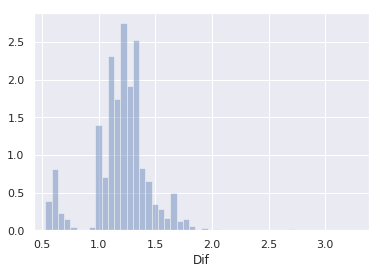

In [18]:
print(f"Difs:{(A @ q - b)[:10]}", end='\n'*2)

neto_col = 'VtaNeta'
res = check_sol(A, q, b, Q=Q)

In [19]:
# Vemos los cambios proporcionales entre el nuevo presupuesto y el anterior

dif = PRESUP.divide(Q.groupby('Prod')['VtaNeta'].sum())
display(dif.sort_values())
display(f"Max: {dif.max():.3f}| Min: {dif.min():.3f} | Mean: {dif.mean():.3f}")
Q['DifProd'] = dif[Q['Prod']].values

Prod
69          0.277926
68          0.326646
254         0.398631
1120        0.401962
3090        0.450653
288         0.474737
1172        0.488993
1171        0.548577
54          0.565005
944         0.572995
438         0.580744
1771        0.593207
1670        0.613379
1661        0.616917
769         0.627993
1629        0.636292
653         0.655964
1870        0.658470
1711        0.660857
711         0.668543
714         0.672762
487         0.676697
660         0.679085
3450        0.680600
3085        0.680800
1655        0.684944
325         0.685562
1710        0.686097
1418        0.689068
1042        0.689124
            ...     
289         0.978796
941         0.988392
635         0.989566
1412        0.997511
3491        1.039314
190         1.047416
376         1.050622
940         1.051760
15          1.057603
1862        1.076837
3710        1.100140
56          1.104681
560         1.163106
724         1.173556
3321        1.201903
1947        1.241589
959     

'Max: 13555.625| Min: 0.278 | Mean: 120.921'

In [20]:
res_0 = (b / (A @ Q['VtaNeta']))
res_warm = (b / (A @ Q['WarmStart']))
res_1 = (b / (A @ Q['Z']))

In [21]:
# Valores proporcionales previos con respecto a los objetivos
res_0

array([    0.692,     1.058,     0.75 ,     0.699,     0.565,     1.105,
           0.86 ,     0.824,     0.708,     0.327,     0.278,  3852.941,
           0.79 ,     0.7  ,     0.838,     0.804, 13555.625,     0.773,
           1.047,     0.752,     0.778,     0.399,     0.741,     0.475,
           0.979,     0.686,     0.779,     0.768,     0.82 ,     1.051,
           0.8  ,     0.924,     0.581,     0.741,     0.757,     0.962,
           0.848,     0.794,     0.677,     1.163,     0.704,     0.875,
           0.892,     0.99 ,     0.808,     0.931,     0.656,     0.679,
           0.825,     0.852,     0.757,     0.832,     0.794,     0.861,
           0.805,     0.669,     0.673,     0.903,     1.174,     0.742,
           0.826,     0.755,     0.771,     0.764,     0.628,     1.425,
           1.347,     0.735,     0.708,     1.052,     0.988,     1.892,
           2.065,     0.573,     1.27 ,     1.3  ,     0.767,     0.825,
           0.689,     0.93 ,     0.402,     0.803, 

In [22]:
# Valores del WarmStart con respecto a los objetivos
res_warm

array([0.757, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   ,

In [23]:
# Valores resultantes 
res_1

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.])

In [24]:
Q.sample(10)

,Periodo,Cliente,Suc,Prod,Flia,VtaNeta,WarmStart,Z,Dif,DifProd
1307518,201909,496990,1,560,1,1.70,1.977280,2.353375,1.190208,1.163106
1132321,201909,484980,1,677,13,0.20,0.166494,0.207281,1.244977,0.832468
1075051,201909,132953,78,476,13,52.35,41.549486,29.590758,0.712181,0.793686
1181607,201909,445412,1,1411,3,0.33,0.288916,0.347830,1.203915,0.875502
929777,201909,428533,1,3346,1,9.00,7.441349,12.452869,1.673469,0.826817
1289792,201909,407798,1,1661,13,0.20,0.123383,0.152416,1.235307,0.616917
410550,201909,450135,1,448,1,1.00,0.961530,1.040882,1.082527,0.961530
1277855,201909,472718,1,706,13,4.00,3.220808,3.270251,1.015351,0.805202
1078834,201909,242801,1,406,7,3.60,2.880523,3.808080,1.322010,0.800145
422656,201909,482999,1,1670,13,1.90,1.165419,1.518980,1.303377,0.613379


In [25]:
PRESUP[151] / Q.groupby('Prod')['VtaNeta'].sum()[151]

13555.625

El algoritmo falla cuando existen valores iguales a 0 en el vector **q** en el momento en el que se calcula **b / Aq**, siendo **b** los objetivos de las restricciones, **A** una matriz binaria que selecciona las variables correspondientes, y **q** el vector con las ventas de cada producto para cada sucursal

In [ ]:
%%time
import scipy.optimize
sol_ = scipy.optimize.minimize(lambda x: np.linalg.norm(A @ x - b, ord=2), q, bounds = [(0, None) for i in range(m)])
sol_sci = sol_['x']

### Notas:
    

In [ ]:
import sqlalchemy
engine = sqlalchemy.create_engine(f"mysql+pyodbc://{UID}:{PWD}@{SERVER}/{DATABASE}?driver=SQL+Server")
df = df.sample(10)
df.to_sql(table_name, con=engine, if_exists='replace')

In [6]:
np.random.seed(101)
p, d, c = 139, 17, 3
t = p*d*c
PRES = np.random.randint(10000, 20000, size = p)
HIST = np.floor(np.random.normal(PRES.sum()//t, size = t))

# Tensor con una var para cada producto+deposito+canal
Q = np.arange(t).reshape((p,d,c))
x = cp.Variable(t)


solvers =  ['CVXOPT', 'GLPK', 'GLPK_MI', 'SCS', 'LS']

objs = [cp.sum_squares(x - HIST), cp.sum_squares(x - HIST) - sum(x), cp.sum_squares(x - HIST) - 2*sum(x), 
        cp.sum_squares(x - HIST) - 3*sum(x), cp.sum_squares(x - HIST) - cp.sum_squares(x)]

In [ ]:
%%time

d = {}
for m in solvers:
    for j in range(len(objs)):
        for z in [0, 1]:
            try:
                d[(m, str(j), ['==', '<='][z])] = solve(p, d, c, PRES, HIST, m, objs[j], z)
            except:
                d[(m, str(j), ['==', '<='][z])] = None

In [ ]:
u,s,vh = sparse.linalg.svds((A @ W).T)
M2, N2 = A.shape
eps = np.finfo(float).eps
tol = max(M2,N2) * np.amax(s) * eps
num = np.sum(s > tol, dtype=int)
ort = u[:,:num]

#### References 


Belotti, P., Kirches, C., Leyffer, S., Linderoth, J., Luedtke, J., & Mahajan, A. (2013). Mixed-integer nonlinear optimization. Acta Numerica, 22, 1-131.

Boyd, S., & Vandenberghe, L. (2004). Convex optimization. Cambridge university press.

Paige, C. C., & Saunders, M. A. (1982). LSQR: An algorithm for sparse linear equations and sparse least squares. ACM Transactions on Mathematical Software (TOMS), 8(1), 43-71.